# Machine Learning - Final Project


## Introduction

### The context of the analysis

**Executive level summary:** We are given a data set of rent payment transaction, and our goal is to extract insight inherent in the data and build a predictive model that leverages those insights (features) to accurately identify tenants who are at risk of falling into long-term arrears.

To achieve the above we need to cater for the following:
1. To clean and pre-process the raw data supplied, so it can be used to generate insight
2. To articulate what long-term arrears means and define a method to flag tenants in long-term arrears (the label)
3. To structure the data in a way that maximises machine learning / model training
4. To analyse and inspect the relationships in the data, and come up with sensible features (the predictors)
5. To shortlist predictive models, and device a framework to implement, calibrate and evaluate the models respective performances on the task at hand
6. To select the best model and assess its out-of-sample performance
7. To extend the model to differentiate between short-term and long- term arrears risk
8. To articulate the assumptions and key design decisions used in this analysis
9. Optional #1 (**Attempted**): To write a recommendation report to the hosing assosiation
10. Optional #2 (**Attempted**): To incorporate zip-code linked features to the model

### Key Assumptions
 
We have 2 sets of assumptions on **data**, which are covered in detail in the section which deals with them (here is a summary):
- How to deal with dates - to fix payment date format issues and missing/erroneous date of births
- How to deal with payment amounts - for the treatment of payments, negative payments and overpayments
       
  
   
We also have a set of key assumptions on **how the rental/payment system works**, which covers the following (note: this might be repeated in the specific sections which deals with these):
- A definition of key terms: 
    - **Arrears**: 
        - A tenant is in arrears if he/she is unable to pay the full rent for a given month  
        - Arrears roll over to the next month if left unpaid.  If it is partially paid, the outstanding amount is rolled over 
    - **Accumulated arrears**: 
        - This is the cummulative amount in arrears, acrued when a tenant does not pay back his/her rent for 2 or more months
        - The accumulated arrears are rolled over as well
        - If a tenant pays off his/her accumulated arrears, then there are no arrears and no more accumulated arrears
    - **Long-Term Arrears:**. 
        - If a tenant is in accumulated arrears for 6 or more months, the tenant is considered in long-term arrears, i.e. he/she was unable to fully pay off the accumulated arrears within 6 month of the first arrears accrual date
    - **Short-Term Arrears:**. 
        - If the maximum time a tenant is in accumulated arrears is between 1-5 months (inclusive) , the tenant is considered to be in short-term arrears, i.e. he/she managed to pay off the accumulated arrears within 5 months of the first arrears accrual date, and the tenant did not fall into a long-term arrears.
    - **Repayment**:
        - Instances where the tenant pays more than the rent due, this is effectively a way to pay back an accumulated arrears


### Key Design Decisions

- **Important Note:** We break the payments of each tenant into 12-months rolling sets, and then compute a set of features from the data inherent in those payment records, which are the following:
    - **Mean Rent Amount** during this period
    - **Number of times in arrears** during this period
    - **Number of repayments** during this period
    - A **risk grade** based on the number of month in accumulated arrears during this period, defined as follows:
        - **Low** risk means one month or less of accumulated arrears
        - **Medium** risk means between 1 and 5 months of accumulated arrears, and
        - **High** risk means a tenant has 6 or more months of accumulated arrears within a 12 months window
    - **Arrear size**, defined as the total amount in arrears (accumulated arrears) as a percentage of average monthly
    - **Multi-Property Renting** - whether a tenant rents more than one property during the 12 month period.
   

- We then enrich these records with features relevant to the tenant, in this case the following:
    - **Date of birth availability** - whether the date of birth is available of not


- By aggregating the above 2 sets, we get a new set which now allows us to learn from a large set of 12-months rental payments.  Once we have trained a model to do so, we can effectively use it to take in any tenant's 12-months payment records, and predict whether the tenant is at risk of falling into long-term arrears.  This is the main objective of this project.


- But, given the above design decision, it implicitly means that any tenant with less than 12 monthly payments is ignored in this analysis, on the basis that 1) we cannot learn from them and 2) we cannot realistically predict whether they will be in long-term arrears or not, given the shortage of data. This only makes ~5% of the tenant population in the data set (analysis provided in this report).


### Hypothesis
- We expect information (features) inherent in the new data set (based on the 12-month rental payment record + tenant-specific feature) to be good predictors of whether a tenant will be in long-term arrears or not.
- We expect the features selected to exhibit statistical significance in the model.
- We expect the following features to be **positively correlated** with being in long-term areas: number of time in arrears, High Risk Grade (based on the lenth of time in accumulated arrears) and size of arrears.
- We expect the following features to be **negatively correlated** with being in long-term arrears: mean rent, number of repayments, Low Risk Grade and multi-property
- The relationship with date of birth availability is less clear, if we assume having the dob data on record is a measure of the quality of the diligence carried out when on-boarding tenants, then we could expect a **negative correlation**, i.e. having a dob on record makes a tenant less likely to be an unknown/risky quantity and therefore less at risk to falling into long-term arrears.
- The relationship with Medium Risk Grade is also potentially an interesting one, all else being equal, we would expect it to be **positively correlated**, given the tenant has been in arrears at some stage.


### Presentation Approach
The first couple of sections of this report deal with loading and cleaning the data.  We then carry a preliminary analysis of the data, followed by an exercise of labelling the data (flagging tenants in long-term arrears).  We then define a list of features (leveraging the 12-months rolling approach described above) and build a new data set.  We use this new data set to answer the questions in Objectives 1 and 2 of this assignment; first by analysis and inspection, secondly by building a regression model to model the relationship of our features to the dependent variable (being in long-term arrears) and finally by leveraging Principal Component Analysis.

We then shift gears and create a shortlist of predictive models (Decision Tree, K-Nearest Neighbours and Naive Bayes), which we train on a training data set, and measure the predictive accuracy of the models on a validation data set. We evaluate the models and pick the most suitable one, which we re-train on the training and validation data set and assess on a testing data set (out-of-sample), and report the findings.

We then extend the model to predict short-term as well as long-term arrears, write a recommendation report to the housing authority based on the findings in this report, and finally we augment our model with demographic data, to improve the predictive accuracy. 

## Load and Clean Data

In [2]:
# Import required libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Part 1: Payment Date Clean-up
  
We check whether the date format makes sense.  To do so, we plot the distribution of months and days from the dataset.

We observe (as illustrated below) that there is a concentration in distribution of months (where month = 1) and a similar concentration in distribution of days (where days in {1-12}), which suggests the date might not be uniformly in the same format.

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


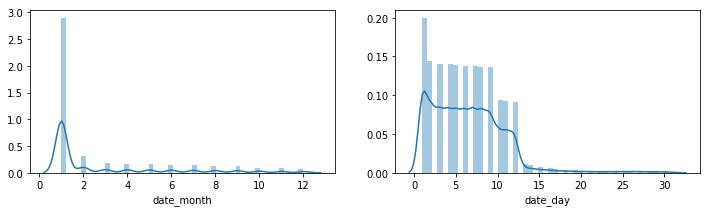

In [3]:
# Split date for analysis 
rental_data[['date_year','date_month','date_day']] = rental_data["paymentDate_clean"].str.split('-',n=2,expand = True)

# Plot months and days
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(1,2,1)
sns.distplot(pd.to_numeric(rental_data['date_month']))
ax = fig.add_subplot(1,2,2)
sns.distplot(pd.to_numeric(rental_data['date_day']))

Further analysis shows that, no tenant has their payment date in mixed format, i.e. both YYYY-MM-DD and YYYY-DD-MM, the format is one or the other.  This is good.

In [4]:
temp = rental_data.groupby(['name']).agg({'date_month':'max', 'date_day':'max'}).reset_index()
len(temp[(temp['date_month'] >'12') & (temp['date_day'] > '12')])

0

#### Assumptions:

We therefore proceed to fix the date format issues using the following logic and assumptions:
1. We assume the payment dates for a given tenant is either in one format (YYYY-MM-DD) or another (YYYY-DD-MM) for any given year, not both

2. We assume the "real" (or correct) month column will have the most distinct number of values, i.e. people typically pay their rent on the same day, but every month.  

3. We make a first pass based on the above logic and switch columns (month/day) accordingly.

4. We make a second pass to switch any individual dates where the month is greater than 12, which is impossible.

**We now proceed to implementing the above:**

In [5]:
# Initiate static values
names = list(set(rental_data['name']))
years = list(set(rental_data['date_year']))
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

# First Pass
for name_i in names:  
    for year_i in years:
        df_i_y = rental_data[(rental_data['name'] == name_i) & (rental_data['date_year'] == year_i)]

        month_len = len([x in months for x in set(df_i_y['date_month'])])
        day_len = len([y in months for y in set(df_i_y['date_day'])])
    
        # if distinct values in days > distinct values in month,switch day and month columns
        if (month_len < day_len):

            #Copy original data: month in temp_month, days in temp_day
            temp_month = list(df_i_y.iloc[:,9])[:]
            temp_day = list(df_i_y.iloc[:,10])[:]

            #Switch the two columns
            ind = df_i_y.index.tolist()
            rental_data.iloc[ind,9] = temp_day
            rental_data.iloc[ind,10] = temp_month

# Second Pass
index_month_more_than_12 = rental_data[rental_data['date_month'] > "12"].index.tolist()
# Copy columns
day_list = rental_data.iloc[index_month_more_than_12,9]
month_list = rental_data.iloc[index_month_more_than_12,10]
# Switch columns
rental_data.iloc[index_month_more_than_12,9] = month_list
rental_data.iloc[index_month_more_than_12,10] = day_list

After the switch, we analyse the data to ensure we don't have a value greater than 12 in the month column.  And we can confirm that is the case.

In [6]:
len(rental_data[rental_data['date_month'] > '12'])

0

We plot the day and month distribution again, and see that the data *now* matches expectations, i.e. uniform distribution of month and skew distribution of days (to 1 of the month, which is usually when many pay their rent).

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


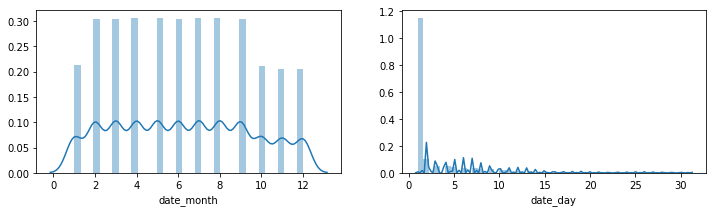

In [7]:
# Plot months and days
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(1,2,1)
sns.distplot(pd.to_numeric(rental_data.iloc[:,-2]))
ax = fig.add_subplot(1,2,2)
sns.distplot(pd.to_numeric(rental_data.iloc[:,-1]))

We update the original payment date to reflect the above transformation.

In [8]:
rental_data['paymentDate_clean'] = rental_data.apply(lambda x: x['date_year'] + '-' 
                                            + x['date_month'] + '-' + x['date_day'], axis=1)
rental_data.head(2)

,Unnamed: 0,name,houseID,houseZip,rentAmount,paymentDate_clean,dob_clean,paymentAmount_clean,date_year,date_month,date_day
0,0,Paulina Lefort,1869,92129,1324.0,2010-02-01,NaN,1324.0,2010,02,01
1,1,Clare Tilly,407,92155,1723.0,2010-02-01,NaN,1723.0,2010,02,01


### Part 2: Payment Amount Cleanup

#### Assumptions:
1. Blank **paymentAmount_clean**: treated as full **rentAmount** unpaid. E.g. if *rentAmount* = 1000, then the rent paid = 0 and amount outstanding = 1000

      
2. Negative **paymentAmount_clean** are treated as the outstanding rent amount (amount in arrears); which follows that rent paid = **rentAmount** + **paymentAmount_clean**.  E.g. if **paymentAmount_clean** = -100 and **rentAmount** = 1000, then the rent paid = 1000 - (-100) = 900  

In [9]:
# Implement Assumption 1 above:
rental_data['paymentAmount_clean'].fillna(0, inplace=True)

# Implement Assumption 2 above:
new_values = []
for index, row in rental_data.iterrows():
    current_value = row['paymentAmount_clean']
    if (current_value < 0):
        new_values.append(row['rentAmount'] + current_value)
    else:
        new_values.append(current_value)

rental_data['paymentAmount_clean'] = new_values

### Part 3: Date of Birth Clean-up
    
**Observations:** The percentage of tenants without a date of birth is ~25%, this potentially hinders our ability to use this data point as a feature in our model by itself.

In [10]:
len(set(rental_data[(rental_data['dob_clean'].isna())]['name']))/len(set(rental_data['name']))

0.25892408245349424

Further analysis shows that ~45% of tenant have the date of birth of **2000-01-01**, which is highly unlikely in such a heterogeneous group, and most probabaly a product of a default date being applied when the date is not available.

#### Assumptions:
- We therefore treat dates with value equal to 2000-01-01 as 0.

This means overall, ~70% (25% + 45%) of tenants either don't have a dob in the dataset, or the dob is incorrect.

In [11]:
len(set(rental_data[(rental_data['dob_clean']=='2000-01-01')]['name']))/len(set(rental_data['name']))

0.4539969834087481

We fill all missing dob with 0, and convert all '2000-01-01' to 0.

In [12]:
rental_data['dob_clean'].fillna(0, inplace=True)
rental_data['dob_clean'] = rental_data['dob_clean'].apply(lambda x: 0 if x == '2000-01-01' else x)

Plot number of records where there is a valid date (1) or 0 (0)

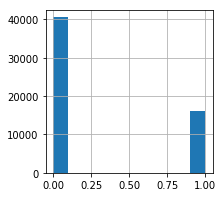

In [13]:
fig = plt.figure(figsize=(3,3))
rental_data['dob_clean'].apply(lambda x: 0 if x==0 else 1).hist()

## Preliminary Analysis of Data

**Distribution of the number of rent payments (records) for each tenant**

**Observations:** Looking the the chart below, most tenants have a large number of payments (~95% have more than 10 payments records).  This is good, as it means we can learn across a longer period of time.

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[Text(0, 0.5, 'cumulative distribution (%)'),
 Text(0.5, 0, 'number of rent payments')]

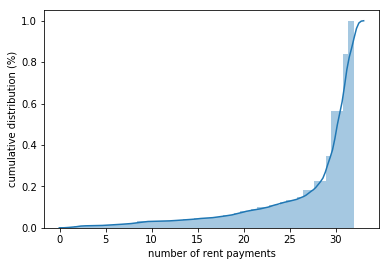

In [14]:
ax = sns.distplot(rental_data.groupby('name').agg({'rentAmount':'count'})['rentAmount'],
                 hist_kws={'cumulative': True},
                 kde_kws={'cumulative': True})
ax.set(xlabel='number of rent payments', ylabel='cumulative distribution (%)')

## Labelling the data

In this section we define a methodology to label the dataset, to identify tenants who are at risk of entering a state of long-term arrears (who fall behind on payments for over 6 months).  We flag tenants who at one stage (based on all the data available) have been in arrears for 6 or more months, in a new field called **long_term_arrears_flag**

#### Key term definitions:
Before we start, let us first define the terms **Arrears, Accummulated Arrears**, **Long Term Arrears** and **Repayment**:
- **Arrears**: 
    - A tenant is in arrears if he/she is unable to pay the full rent for a given month  
    - Arrears roll over to the next month if left unpaid.  If it is partially paid, the outstanding amount is rolled over 
- **Accumulated arrears**: 
    - This is the cummulative amount in arrears, acrued when a tenant does not pay back his/her rent for 2 or more months
    - The accumulated arrears are rolled over as well
    - If a tenant pays off his/her accumulated arrears, then there are no arrears and no more accumulated
- **Long Term Arrears:**. 
    - If a tenant is in accumulated arrears for 6 or more months, the tenant is considered in long-term arrears, i.e. he/she was unable to fully pay off the accumulated arrears within 6 month of the first arrears accrual
- **Repayment**:
    - Instances where the tenant pays more than the rent due, this is effectively a way to pay back an accumulated arrears

**Step 1:** Calculate the monthly outstanding rent (**outstanding_amount**), defined as Rent Due (rentAmount) - Rend Paid (paymentAmount_clean).  

Add a binary arrears flag (**arrears_flag**), which is 1 if there are any arrears for any given month, and 0 otherwise.

Add a binary over-payment flag (**overpayment_flag**), which is 1 if a tenant pays more that the rent due, e.g. if paying back accumulated arrears, and 0 otherwise.  Note: This is used in the next section.

In [15]:
rental_data_copy = rental_data.copy()
rental_data_copy['outstanding_amount'] = rental_data_copy['rentAmount'] - rental_data_copy['paymentAmount_clean']
rental_data_copy['arrears_flag'] = rental_data_copy['outstanding_amount'].apply(lambda x: 1 if x > 0 else 0)
rental_data_copy['repayment_flag'] = rental_data_copy['outstanding_amount'].apply(lambda x: 1 if x < 0 else 0)

**Step 2:** Re-sort the data ready for enrichment, using **name**, **houseID** and **paymentDate_clean**, to ease computation.

In [16]:
rental_data_copy = rental_data_copy.sort_values(['name', 'houseID', 'paymentDate_clean'])
rental_data_copy.reset_index(inplace=True, drop=True)
rental_data_copy = rental_data_copy[['name','houseID','rentAmount','paymentAmount_clean','paymentDate_clean', 
                                     'outstanding_amount', 'arrears_flag', 'repayment_flag']]

# rename columns for improve readbility
rental_data_copy.rename(columns={'paymentAmount_clean':'paymentAmount', 
                                 'paymentDate_clean': 'paymentDate'}, inplace=True)

**Step 3:** Calculate a cummulative arrear (**cum_arrears**) for each tenant (and property), as and a arrear counter (**arrears_counter**) to identify consecutive periods of arrears.

In [17]:
rental_data_copy['cum_arrears'] = 0
rental_data_copy['arrears_counter'] = 0
cum_arrears = []

for i in range(len(rental_data_copy)-1):
    current = rental_data_copy.iloc[i]
    
    if (i == 0):
        new_cum_arrears = max(current['outstanding_amount'], 0)
        cum_arrears.append(new_cum_arrears)
        
        # Update the value of cum_arrears, with the new value
        rental_data_copy.iat[i, rental_data_copy.columns.get_loc("cum_arrears")] = new_cum_arrears
        
        if new_cum_arrears > 0:
            # Update the value of arrears_counter, with the new value
            rental_data_copy.iat[i, rental_data_copy.columns.get_loc("arrears_counter")] = 1

    else:
        previous = rental_data_copy.iloc[i-1]
        if (current['name'] == previous['name']) & (current['houseID'] == previous['houseID']):
            new_cum_arrears = max(previous['cum_arrears'] + current['outstanding_amount'], 0)
            cum_arrears.append(new_cum_arrears)
            
            # Update the value of cum_arrears, with the new value
            rental_data_copy.iat[i, rental_data_copy.columns.get_loc("cum_arrears")] = new_cum_arrears
            
            if new_cum_arrears > 0:
                # Update the value of arrears_counter, with the new value
                rental_data_copy.iat[i, rental_data_copy.columns.get_loc("arrears_counter")] = previous['arrears_counter'] + 1
        else:
            new_cum_arrears = max(current['outstanding_amount'], 0)
            cum_arrears.append(new_cum_arrears)
            
            # Update the value of cum_arrears, with the new value
            rental_data_copy.iat[i, rental_data_copy.columns.get_loc("cum_arrears")] = new_cum_arrears
            
            if new_cum_arrears > 0:
                # Update the value of arrears_counter, with the new value
                rental_data_copy.iat[i, rental_data_copy.columns.get_loc("arrears_counter")] = 1

# An example to illustrate what this achieves
rental_data_copy.iloc[622:630] # Aimee Macke

,name,houseID,rentAmount,paymentAmount,paymentDate,outstanding_amount,arrears_flag,repayment_flag,cum_arrears,arrears_counter
622,Aimee Macke,28,1318.0,1318.0,2010-07-01,0.0,0,0,0,0
623,Aimee Macke,28,1318.0,0.0,2010-08-03,1318.0,1,0,1318,1
624,Aimee Macke,28,1318.0,1318.0,2010-09-06,0.0,0,0,1318,2
625,Aimee Macke,28,1318.0,1318.0,2010-10-03,0.0,0,0,1318,3
626,Aimee Macke,28,1318.0,1318.0,2010-11-07,0.0,0,0,1318,4
627,Aimee Macke,28,1318.0,1318.0,2010-12-04,0.0,0,0,1318,5
628,Aimee Macke,28,1318.0,1318.0,2011-01-03,0.0,0,0,1318,6
629,Aimee Macke,28,1318.0,1318.0,2011-02-02,0.0,0,0,1318,7


A quick look at the distribution of time in arrears.

**Interim Analysis commentary:**   
The below histogram plots the maximum time in accumulated arrears for each tenant, we can see that most tenants are never in arrears during the period of analysis (maximum time = 0).  We can also observe that we have a decent (albeit smaller) distribution of tenants in accumlulated arrears between 2 and 30, with no easily observable skew.

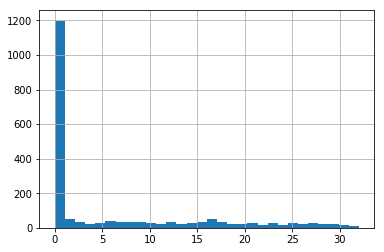

In [18]:
rental_data_copy.groupby('name').agg({'arrears_counter':'max'})['arrears_counter'].hist(bins=30)

**Step 4:** Get a list of all tenants who have been in accumulated arrears for 6 or more months

In [19]:
max_counter = rental_data_copy.groupby('name').agg({'arrears_counter':'max'})
tenants_in_long_term_arrears = list(max_counter[(max_counter['arrears_counter'] >=6 )].index)

**Step 5:** Add the above as a label to the rental dataset for each tenant

We now have a label for each tenant.  This label shows us whether the tenant is in long-term arrears at any stage, based on the payments data we hold on them.  
 
In the below example, Abe Prophet and Adeline Hodgkinson are flagged as tenants who have gone in long term arrears.

In [20]:
rental_data_copy['long_term_arrears_flag'] = rental_data_copy['name'].apply(lambda x: 1 if x in tenants_in_long_term_arrears else 0)

# An example to illustrate what this achieves
rental_data_copy.groupby(['name']).agg({'long_term_arrears_flag':'mean'}).head(10)

,long_term_arrears_flag
name,
Aaron Huston,0
Abbey Kluth,0
Abe Prophet,1
Abel Emmett,0
Abraham Maggi,0
Adah Curnutt,0
Adaline Santos,0
Adan Havlik,0
Adelia Terwilliger,0


## Building a list of features

### **Feature Set 1: Stats related to the 12-months payments**  
We plan to have a record for each consecutive 12-month period for any tenant (and a given property).

For tenants who have at least 12 months payments for one property, for each consecutive 12-month period, we compute the following 5 features:

1. **Mean Rent Amnount** during this period
2. **Number of times in arrears** during this period
3. **Number of repayments** during this period
4. A **risk grade** based on the number of month in accumulated arrears during this period, defined as follows:
    - **Low** risk means one month or less of accumulated arrears
    - **Medium** risk means between 1 and 5 months of accumulated arrears, and
    - **High** risk means a tenant has 6 or more months of accumulated arrears within a 12 months window


4. **Arrear size**, defined as the total amount in arrears (accumulated arrears) as a percentage of average monthly
5. **Multi-Property Renting** - whether a tenant rents more than one property during the 12 month period.

**Step 1:** Build a set of 12-month (rolling) payments for each tenant

In [21]:
# Define a function to take in a 12-month set of outstanding amount and 
# calculate the max accumulated arrears for that period 
# Note: this is different to the arrear_counter used across the whole set
# of payments

def get_max_cum_arrears_in_period(data):
    max_value = 0
    cum_sum = 0
    arrears_counter = 0
    for i in data:
        cum_sum += i
        if cum_sum > 0:
            arrears_counter += 1
            max_value = max(max_value,arrears_counter)
        if cum_sum <= 0:
            arrears_counter = 0
    return max_value

In [22]:
# Initialise a dictionary to store this data set
month_rolling_dataset = {}

for i in range(len(rental_data_copy)-1):
#for i in range(600,700):
    
    month_rolling_list = []
    start = rental_data_copy.loc[i]
    
    # If we are not at the end of the dataset, i.e. we have 12 or more records
    if (i+11 < len(rental_data_copy)-1):
        
        # Get the next 12 payments
        data = rental_data_copy.loc[i:i+11]
        
        # Check all record belong to the same tenant and property
        if (data.iloc[0]['name'] == data.iloc[11]['name']) & (data.iloc[0]['houseID'] == data.iloc[0]['houseID']):            
            
            # Get name and house ID
            month_rolling_list.append(data.iloc[0]['name'])
            month_rolling_list.append(data.iloc[0]['houseID'])
            
            # Get mean rent in the 12-month period
            month_rolling_list.append(data['rentAmount'].mean())
            
            # Get number of times a tenant is in arrear in the 12-month period
            sum_of_arrears = data['arrears_flag'].sum()
            month_rolling_list.append(sum_of_arrears)

            # Get number of repayments in the 12-month period
            sum_of_repayments = data['repayment_flag'].sum()
            month_rolling_list.append(sum_of_repayments)
            
            # Get Risk Grade
            max_cum_arrears = get_max_cum_arrears_in_period(data['outstanding_amount'])
            if max_cum_arrears <= 1:
                risk_grade = 'Low'
            elif max_cum_arrears <= 5:
                risk_grade = 'Medium'
            else:
                risk_grade = 'High'
            month_rolling_list.append(risk_grade)
            
            # Get Total amount in arrears as a percentage of average monthly
            # = last value of cummulative arreas divided by average rentAmount
            tota_arrears_vs_avg_rent = data.iloc[11]['cum_arrears']/data['rentAmount'].mean()
            month_rolling_list.append(tota_arrears_vs_avg_rent)
            
            # Get Multi-Property Ownership
            property_data = rental_data_copy[(rental_data_copy['name'] == data.iloc[0]['name']) &
                                             (rental_data_copy['paymentDate'] >= data.iloc[0]['paymentDate']) &
                                             (rental_data_copy['paymentDate'] <= data.iloc[11]['paymentDate'])]
            property_count = (1 if property_data['houseID'].nunique() > 1 else 0)
            month_rolling_list.append(property_count)
             
            # Write record to dictionary
            month_rolling_dataset[(start['name'], start['houseID'], start['paymentDate'])] = month_rolling_list

**Step 2:** Clean up the inputs

In [23]:
inputs = pd.DataFrame.from_dict(month_rolling_dataset, orient='index')
inputs.reset_index(drop=True, inplace=True)

# Rename columns
column_names = {0:'name',
                1:'houseID',
                2:'mean_rent',
                3:'arrears_count',
                4:'repayment_count',
                5:'risk_grade',
                6:'arrears_size', 
                7:'multi_property'}
inputs.rename(columns=column_names, inplace=True)

# Take out duplicates
#inputs = inputs.drop_duplicates()

# Example to illustrate what this piece achieves
inputs[(inputs['name']=='Aimee Macke')]

,name,houseID,mean_rent,arrears_count,repayment_count,risk_grade,arrears_size,multi_property
386,Aimee Macke,28,1318.0,1,1,High,1.000000,0
387,Aimee Macke,28,1318.0,1,0,High,1.000000,0
388,Aimee Macke,28,1318.0,1,0,High,1.000000,0
389,Aimee Macke,28,1318.0,1,0,High,1.000000,0
390,Aimee Macke,28,1318.0,1,0,High,1.000000,0
391,Aimee Macke,28,1318.0,1,0,High,1.000000,0
392,Aimee Macke,28,1318.0,1,0,High,1.000000,0
393,Aimee Macke,28,1318.0,0,0,Low,1.000000,0
394,Aimee Macke,28,1318.0,0,1,Low,0.900607,0
395,Aimee Macke,28,1318.0,0,1,Low,0.900607,0


In [24]:
# Take an interim copy of inputs (just in case)
#backup = inputs.copy()

In [25]:
#inputs = backup.copy()

### **Feature Set 2: Stats related to the tenant**  

For each tenant or property we compute the following stats, to be used as features:
1. **Date of birth availability** - the **Prelinimary Analysis** section, Part B, we find that dob is missing (or bogus) for ~70% of tenants, instead of using the dob itselt, we instead use whether it is available or not as a feature.  This feature holds the following binary values:

    - **1**: dob available
    - **0**: dob not available

In [26]:
dob_review = rental_data.groupby(['name']).agg({'dob_clean':'max'})
dob_review.fillna(0, inplace=True)
dob_review['dob_available'] = dob_review['dob_clean'].apply(lambda x: 0 if x == 0 else 1)
inputs = inputs.merge(dob_review.reset_index()[['name','dob_available']],
                       left_on=['name'], right_on=['name'])
inputs.head(1)

,name,houseID,mean_rent,arrears_count,repayment_count,risk_grade,arrears_size,multi_property,dob_available
0,Aaron Huston,1,1720.0,0,0,Low,0.0,0,0


## Building a new data set for analysis

Now that we have computed the labels and built a set of features, we collate these into a new dataset. 

In [27]:
labels = rental_data_copy.groupby(['name']).agg({'long_term_arrears_flag':'max'})
new_rental_data = inputs.merge(labels,left_on=['name'], right_on=['name'])

# An example to illustrate the output
new_rental_data.loc[383:388]

,name,houseID,mean_rent,arrears_count,repayment_count,risk_grade,arrears_size,multi_property,dob_available,long_term_arrears_flag
383,Aida Osterman,27,1948.0,0,0,Low,0.0,0,0,0
384,Aida Osterman,27,1948.0,0,0,Low,0.0,0,0,0
385,Aida Osterman,27,1948.0,0,0,Low,0.0,0,0,0
386,Aimee Macke,28,1318.0,1,1,High,1.0,0,0,1
387,Aimee Macke,28,1318.0,1,0,High,1.0,0,0,1
388,Aimee Macke,28,1318.0,1,0,High,1.0,0,0,1


# Objectives 1 and 2
1. **Can you and your group differentiate between those who are likely to pay
back their debt quickly vs those who are more at risk of entering a state of
long-term arrears (which accounts for the majority of arrears debt)?  To be
more specific, who's likely to fall behind on payments for over 6 months
and who's likely to catch up.**


2. **Is there a single factor with the strongest predictive power, or is it a subtle combination of factors? How do these combinations vary?**

In the above section ("Labelling he data"), we device a methodology to identify tenants who fall in long-term arrears. In the subsequent section ("Building a list of features"), we compute a set of variables which we think have a predictive power on determining whether a tenant is **likely** to go into long-term arrears.

We answer these questions using 2 different methods:
1. By analysis and inspection of the data
2. By building a multiple linear regression model to investigate the relationship of our list of features and the probability of a tenant going in long-term arrears

### Part 1 - Analysis and Inspection
To aid this analysis, we plot a distribution of all the features (identified in section "Building a list of features"), split on long-term arrears label we computed.  

Below, the **orange** distribution represents tenants in long-term arrears, and the **blue** distrubtion represent tenants not in long-term arrears.

For ease in this section, let's refer to long-term arrear as **LTA**, and not in long-term arrears as **not in LTA**.

**Observations by inspection:** (refer to histograms below)
- **Mean Rent (mean_rent)**: It looks like tenants in LTA have a slight tilt to the left (towards lower rent) and the opposite observed for tenants not in LTA.
- **Number of Arrears (arrears_count)** and **Arrears Size (arrears_side)**: tenants in LTA tent to exhibit higher values of both, relative to tenants not in LTA
- **Number of Repayments (repayment_count):** tenants not in LTA tend to have more repayments than tenants in LTA
- **Risk Level**:
    - **High Risk (risk_grade_high):** a higher proportion of tenant in LTA have a value of 1, compared to tenants not in LTA
    - **Medium Risk (risk_grade_medium):** a higher proportion of tenant in LTA have a value of 1, compared to tenants not in LTA
    - **Low Risk (risk_grade_medium):** a higher proportion of tenant **not in LTA** have a value of 1, compared to tenants in LTA
- By inspection only it is hard to distinguish the relationship of the following features:
    - **Multi-Property (multi_property)**
    - **Date of birth availability (dob_availability)**
    
#### **Conlusions:**  
Some intuition can be built by visualising and analysing the distributions within the data set, for e.g. we can say that **tenants with low rent, multiple arrears, larger arrears amount, smaller number of repayments and who have a risk grade of medium or high (based on 12-month accumulated arrears) are at higher risk of falling into long-term arrears**.  Having said that, this intuition is very limited and would be hard to apply in practice. We also fail to understand the relatively strenght of the predictors and whether they are statistically significant or just noise.  

The approach in the next section - Multiple Linear Regression - aims to provide a better method to analyse this problem.

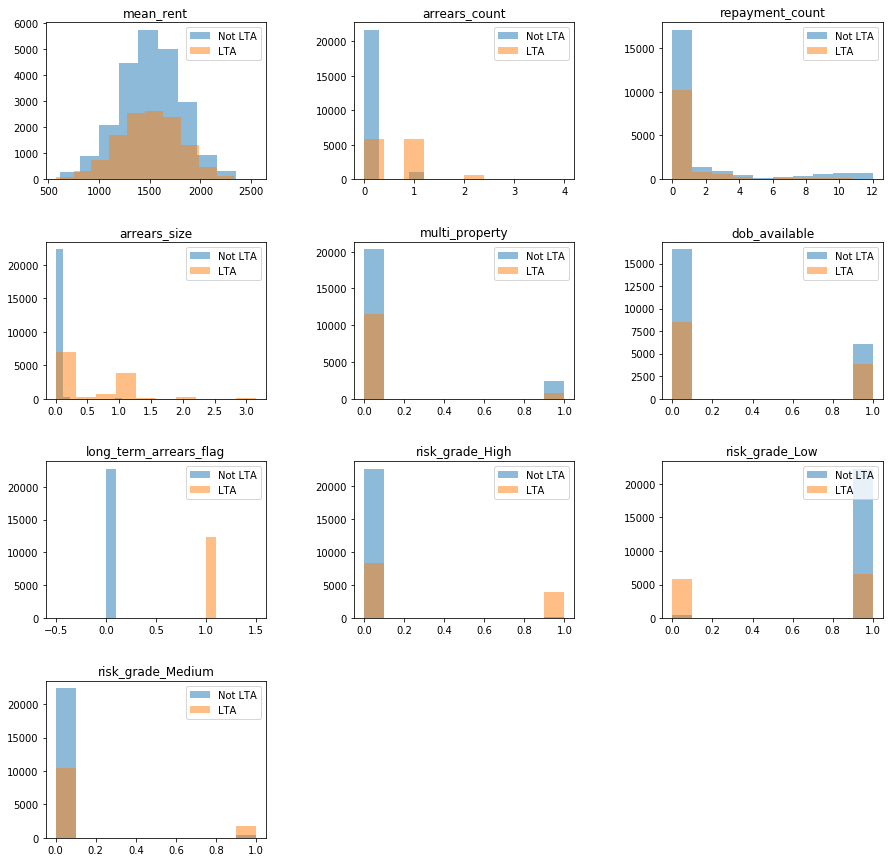

In [28]:
from matplotlib import pyplot
fig = plt.figure(figsize=(15,15))

# Build a clean plot data set
plot_data = pd.get_dummies(new_rental_data[new_rental_data.columns[2:]])

for i in range(len(plot_data.columns)):
    ax = fig.add_subplot(4,3,i+1)
    pyplot.hist(plot_data[(plot_data['long_term_arrears_flag']==0)][plot_data.columns[i]], alpha=0.5, label='Not LTA')
    pyplot.hist(plot_data[(plot_data['long_term_arrears_flag']==1)][plot_data.columns[i]], alpha=0.5, label='LTA')
    pyplot.legend(loc='upper right')   

    ax.set_title(plot_data.columns[i])
    plt.subplots_adjust(wspace = 0.4, hspace = 0.4)

### Part 2 - Regression Approach

We first build the data to support a multiple linear regression  

- The **dependent variable** (y) in this model is the flag we have for whether a tenant is at risk of long-term arrear or not; **long_term_arrears_flag**  
- The **independent variables** (x's) are all the features we've built in the previuos section
 
**From the above Multi Regession Model, we can observe the following:** (please refer to regression summary below)  

All the variables included in the model are **statistically significant** at the 5% level (i.e. p-value < 0.05).  This mean the model is appropriately formulated and does not suffer from fucntional form misspecification.

On closer inspection, the relationship between the independent variables and the dependent variables all make sense, and are mostly in-line with our initial hypothesis (in the introduction section):  
  
- The following independent variables are **positively correlated** to the dependent variables:
    - As number of arears goes up (**arrears_count**), the probability of being at risk of long term arrears also goes up.
    - The same applies for the size of the arrears relative to the mean rent (**arrears_size**), the risk grade being high (**risk_grade_high**)
    - Interesting to see that the medium risk grade (**risk_grade_medium**) is also positively related to the dependent variable, this makes sense; as the risk grade goes up, we expect the tenant probability of getting in long-term arrears to also go up  
    - Interestingly date of birth availability (**dob_available**) is positively correlated, which goes again our initial hypothesis.


- The following variable are **negatively correlated** to the dependent variables:
    - As mean rent (**mean_rent**) goes up, the probability of going in long term arrears goes down, which is understandable, tenant with higher rents are typically wealthier and more likely to be able to pay their rent
    - The same logic applies to multi-property (**multi_property**)
    - The higher the number of repayment (repayment_count), the lower the probability that the tenant goes into long-term arrears, same for risk grade of low (**risk_grade_low**).

In [29]:
import statsmodels.formula.api as smf

model_data = pd.get_dummies(new_rental_data[new_rental_data.columns[2:]])

# create a fitted model with all three features
lm1 = smf.ols(formula='long_term_arrears_flag ~ mean_rent + arrears_count + repayment_count + arrears_size \
              + multi_property + dob_available + risk_grade_High + risk_grade_Low + risk_grade_Medium'
              , data=model_data).fit()

# Print Summary
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     long_term_arrears_flag   R-squared:                       0.430
Model:                                OLS   Adj. R-squared:                  0.430
Method:                     Least Squares   F-statistic:                     3307.
Date:                    Mon, 15 Jul 2019   Prob (F-statistic):               0.00
Time:                            12:33:30   Log-Likelihood:                -13971.
No. Observations:                   35042   AIC:                         2.796e+04
Df Residuals:                       35033   BIC:                         2.804e+04
Df Model:                               8                                         
Covariance Type:                nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.3364      0.009     37.633      0.000       0.319       0.354
mean_rent         -1.335e-05   6.44e-06     -2.073      0.038    -2.6e-05   -7.29e-07
arrears_count         0.0711      0.008      8.478      0.000       0.055       0.088
repayment_count      -0.0076      0.001    -10.569      0.000      -0.009      -0.006
arrears_size          0.4434      0.006     76.199      0.000       0.432       0.455
multi_property       -0.0490      0.007     -7.290      0.000      -0.062      -0.036
dob_available         0.0136      0.004      3.167      0.002       0.005       0.022
risk_grade_High       0.2730      0.007     38.422      0.000       0.259       0.287
risk_grade_Low       -0.1177      0.006    -20.512      0.000      -0.129      -0.106
risk_grade_Medium     0.1811      0.008     24.011      0.000       0.166       0.196
==============================================================================
Omnibus:                     5138.675   Durbin-Watson:                   0.182
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7691.232
Skew:                           1.117   Prob(JB):                         0.00
Kurtosis:                       3.523   Cond. No.                     4.42e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.22e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Further analysis on Objectives 1 and 2:

The output of our model shows the correlation of each feature in regards to determining long-term arrears. Another more advanced technique used a lot in Finance Stock Market analysis is **Principal Component Analysis**. Predominantly used in very high dimensional data, its aim is to find new axis for the data to analyse if, in fact a suttle linear combination (correlated independent variables) that form to become uncorrelated predictors of variables provided more explanatory power for our dependent variable (y) than each feature in isolation. Our transformed dataset only has 9 independent variables (low-dimension) but I thought it would be interesting to explore all the same.

**Process for PCA:**
- Convert all non-numerical features to numerical
- Standardise to be centered around 0 with standard deviation of 1 (to ensure variance is correctly maximised)
- Calculate the eigen decomposition of the correlation matrix
- PC1 - directional line that minimises the sum of square residuals and identifies the maximum variance
- We can then continue to produce orthogonal lines up to PC "N" reducing in variance with descending eigenvalues
- Review "explained variance" which gives us an indication of how much information can be attributed to each principal component.

In [30]:
#Prinicpal Component Analysis

X = plot_data.copy()
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.preprocessing import StandardScaler
import plotly
import plotly.plotly as py
plotly.tools.set_credentials_file(username='smtonks2712', api_key = 'tedHO7yfvDRmAAn9kNMB')

#Standardise
X_std = StandardScaler().fit_transform(X)
sklearn_pca = sklearnPCA(n_components=1)
Y_sklearn = sklearn_pca.fit_transform(X_std)

#Create Covariance
mean_vec = np.mean(X_std, axis=0)
cov_mat = (X_std-mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
#print('Covariance matrix \n%s' %cov_mat)

#Eigen decomposition
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
#print('Eigenvectors \n%s' %eig_vecs)
#print('Eigenvalues \n%s' %eig_vals)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning:

Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.

/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning:

Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.



Now that we produced the eigenvectors and 9 eigenvalues representing each feature (independent variable) we now rank each pair by Eigen value in decending order. The highest eigenvalue represents the largest amounnt of information that concludes whether an indidividal is likely to fall into long-term arrears

In [31]:
#Create tuple for list of 
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

#Sort high to low
eig_pairs.sort()
eig_pairs.reverse()

print('Eigenvalues in Descending Order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in Descending Order:
3.6115083379272406
1.1082486745086118
1.0575252183952781
1.0202353877158132
0.9949210707351503
0.9466291468054417
0.6764971070462155
0.41975138087174674
0.16496905597794886
4.748442959295904e-16


In [32]:
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)

#1-10 for each feature
trace1 = dict( type = 'bar', x = ['PC %s' %i for i in range(1,11)], y =var_exp, name = 'Individual')
trace2 =  dict( type = 'scatter', x = ['PC %s' %i for i in range(1,11)], y =cum_var_exp, name = 'Cumulative')

data = [trace1, trace2]

layout = dict( title = 'Explained Variance by Different Principal Components', \
              yaxis = dict( title = 'Explained Variance in Percentage'), \
              annotations = list([dict(x=1.16,\
                                       y=1.05,\
                                       xref='paper', \
                                       yref='paper',\
                                       text='Explained Variance',\
                                       showarrow=False,)]))
fig = dict(data=data,layout=layout)


py.iplot(fig, filname = 'Selection Principal Components')

In [33]:
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)

#1-10 for each feature
trace1 = dict( type = 'bar', x = ['PC %s' %i for i in range(1,11)], y =var_exp, name = 'Individual')
trace2 =  dict( type = 'scatter', x = ['PC %s' %i for i in range(1,11)], y =cum_var_exp, name = 'Cumulative')

data = [trace1, trace2]

layout = dict( title = 'Explained Variance by Different Principal Components', \
              yaxis = dict( title = 'Explained Variance in Percentage'), \
              annotations = list([dict(x=1.16,\
                                       y=1.05,\
                                       xref='paper', \
                                       yref='paper',\
                                       text='Explained Variance',\
                                       showarrow=False,)]))
fig = dict(data=data,layout=layout)


py.iplot(fig, filname = 'Selection Principal Components')

Interestingly we see that we that if we were to reduce our model by 2 dimensions from a 9 dimensional space into a 7 dimensional space we would still have a combined explanatory power of 98.16% and be confident that each of the transformed covariants are uncorrelated thus reducing the likelyhood of producing a bias in our model.

# Objectives 3

3. **Can you produce a predictive model that produces a score card for the risk of long term arrears (e.g., over 6 months) for each tenant?**

### Approach for tackling this section:
- For each model below, we first train the model on the **Training** data set and assess each model's performance on the **Validation** data set, using the following measure; accuracy, confusion matrix outputs (TP, FP, TN, FN) as well as sensitivity and specificity scores.
- We then compare and evaluate the performance of each model, before picking the most suitable model.
- We then retrain the favoured model on the **Training + Validation** data sets, and assess its performance on the **Testing** data set, as a way to measure the model's generalisation accuracy.

### Selection of models in-scope for this analysis:
- Naive Benchmark - to be used as a benchmark, or lower bound for performance measurement
- Decision Tree 
- K Nearest Neighbours (KNN)
- Naive Bayes

Note: The basis of selection was primarily to focus on supervised leanring techniques, given we can identify instances where tenants go into long-term arrears, and use this information when learning.  Having said that, we would have wished (time permitting) to have extended this analysis to capture an unsupervised learning method, e.g. k-means.  We would have also liked to include a Random Forest implementation, as a way to explore an **ensemble** model.

### Prep data ahead of model training
We first start by computing the inputs (X's) and output (y).

We shuffle the data and split it into Traning, Validation and Testing data sets.

In [34]:
from sklearn.model_selection import train_test_split
seed = 100
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
import pydotplus
import string
from sklearn.externals.six import StringIO  
from IPython.display import Image 
from sklearn import tree
from sklearn.tree import export_graphviz

# Remove name houseid columns
X = pd.get_dummies(new_rental_data[new_rental_data.columns[2:-1]])
y = new_rental_data['long_term_arrears_flag']

# Use 50% of the data for Training, 25% for Validation and 25% for Testing
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.25, 
                                                            shuffle = True, random_state = seed)

X_train, X_val, y_train, y_val = train_test_split(X_train_val,y_train_val, test_size =1/3, 
                                                  shuffle = True, random_state = seed )

#print out the count of messages of each data set to check if the code is correct. 
print('X_train:',len(X_train), '\nX_val:',len(X_val), '\nX_test:', len(X_test))

X_train: 17520 
X_val: 8761 
X_test: 8761


## Approach 0: Naive Benchmark 

The naive benchmark here refers to the majority predictor, i.e. the output mode

The accuracy of the majority predictor is observed to be 0.647 (or 64.7%). **This means that the majority class (not at risk of falling into long-term arrears) is ~64.7% of the validation set**, so if we assign the majority output as the prediction, we will be correct for 64.7% of the time.

As shown below, the sensitivity of the classifier is 0. This means that the naive benchmark model would not detect any tenant at risk of falling into long-term arrears. The specificity is equal to 1, which means that the naive benchmark will correctly identify all tenants with long term arrears equal to 0 (i.e. not a risk in failling into long-term arrears).  

We conclude that the majority predictor does a poor job at predicting tenants at risk of falling into long-term arrears, as expected.

In [35]:
# Identify mode (majority class)
print('Mode:', y_train.mode()[0])

#show accuracy of naive Bayes, assuming that we assign the majority predictor (arrears==1)
accuracy = round((y_val == y_train.mode()[0]).sum()/len(y_val),3)
print ('Accuracy of majority predictor:', accuracy)

Mode: 0
Accuracy of majority predictor: 0.647


We compute and store the confusion matrix results for later comparison.

In [36]:
y_naive_pred = np.zeros(y_val.shape[0])
tn, fp, fn, tp = confusion_matrix(y_val, y_naive_pred).ravel()
sensitivity = round(tp/(tp+fn),2)
specificity = round(tn/(tn+fp),2)

# Store output
performance_dict = {}
performance_dict['Naive Benchmark'] = [tn,fp,fn,tp,sensitivity,specificity, accuracy]

print(' tn:',tn,"\n",'fp:',fp,'\n','fn:',fn,'\n','tp:',tp)
print(" sensitivity:", sensitivity,'\n','specificity:',specificity)

 tn: 5665 
 fp: 0 
 fn: 3096 
 tp: 0
 sensitivity: 0.0 
 specificity: 1.0


## Approach 1: Decison Tree

The first model we implement is the Decision Tree Classifier.  

**Step 1:**   
We train a Decision Tree Classifier with the default settings (i.e.Gini criterion, max depth=None). We first train our classifier and then we calculate the accuracy of the tree on the Training and Validation sets.  

We see that the accuracy of the Training set is 98.4% and the accuracy of the Validation set is 95.0%. This is a significant improvement (and a bit surprising) for the Validation set, compared to the naive benchmark classifier (as expected).

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Initialise and train classifier
DT_default = DecisionTreeClassifier(random_state = 100)
DT_default.fit(X_train,y_train)

# Predict output for Training and Validation data sets
y_train_pred = DT_default.predict(X_train)
y_val_pred = DT_default.predict(X_val)

print ('Training set accuracy  : ', accuracy_score(y_train,y_train_pred))
print ('Validation set accuracy: ', accuracy_score(y_val,y_val_pred))

Training set accuracy  :  0.9848173515981735
Validation set accuracy:  0.9504622759958908


**Step 2:** We proceed to identify the optimal max_depth for our Decision Tree Classifer.

We first define a function for getting the accuracy of the decision tree.

In [38]:
def get_dtc_accuracy(max_depth=None, crit='gini'):
    
    # Initialise and train classifier
    DT_default = DecisionTreeClassifier(random_state = 100, max_depth= max_depth, criterion=crit)
    DT_default.fit(X_train,y_train)

    # Predict output for Training and Validation data sets
    y_train_pred = DT_default.predict(X_train)
    y_val_pred = DT_default.predict(X_val)    

    return (accuracy_score(y_train,y_train_pred), accuracy_score(y_val,y_val_pred))

We use the following purity measures - entropy and the gini index to identify the max_depth which delivers the highes prediction accuracy.

----- entropy -----
Max. depth with highest Accuracy on Training data  : 53 (with accuracy: 0.9848173515981735 )
Max. depth with highest Accuracy on Validation data: 54 (with accuracy: 0.9496632804474375 )
----- gini -----
Max. depth with highest Accuracy on Training data  : 49 (with accuracy: 0.9848173515981735 )
Max. depth with highest Accuracy on Validation data: 50 (with accuracy: 0.9504622759958908 )


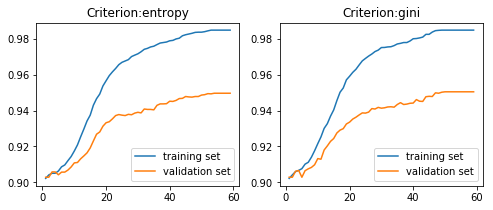

In [39]:
# Impurity measures to test
criterions = ['entropy', 'gini']

fig = plt.figure(figsize=(8,3))

for num, c in enumerate(criterions):
    # Dictionary to store accuracies scores
    summary = {}
    for i in range(1,60):
        summary[i] = get_dtc_accuracy(i, c)

    summary_df = pd.DataFrame.from_dict(summary, orient='index')
    summary_df.columns = ['Training Set Accuracy', 'Validation Set Accuracy']

    print ('-----', c, '-----')
    print('Max. depth with highest Accuracy on Training data  :', summary_df['Training Set Accuracy'].idxmax(), \
                 '(with accuracy:', summary_df.loc[summary_df['Training Set Accuracy'].idxmax()][0], ')')
    print('Max. depth with highest Accuracy on Validation data:', summary_df['Validation Set Accuracy'].idxmax(), \
                 '(with accuracy:', summary_df.loc[summary_df['Validation Set Accuracy'].idxmax()][1], ')')

    ax = fig.add_subplot(1,2,num+1)
    ax.set_title('Criterion:' + c)
        
    ax.plot(summary_df)
    ax.legend(['training set','validation set'],loc="lower right")

### Analysis comments:

We find that a max_depth of 50 (according to the gini index) gives us the highest accuracy of ~95% on the **Validation** data set, which is only slighty less that the ~98% achieved on the **Training** data set.

We notice that the accuracy starts at a realtively high point (~90%) and gradually increases to ~95% for the **Validation** data set, and ~98% achieved on the **Training** data set.  The high starting point is surprising, and initially made us wary something might be wrong, for example, overfitting, which is a typical challenge when using Decision Tree Classifier.  We therefore, proceed with further validating the max depth using **K-fold Cross-Validation**, as a way to cross-check our initial analysis.

Implementations notes:
- We use a 3-fold cross-validation (cv=3) to mimic the 2:1 Training to Validation data set split. We tested with different values of cv (5 and 7), but observed no change in either the best accuracy score or best max depth level.
- We use both the Training and Validation data for this cross-validation analysis
- We test both Gini and Entropy, as purity measures

### Outcome summary:
The max depth with the highest accuracy is 56 (using gini index) with an accuracy score of 95%. Based on the above analysis, we have decided to use a max depth of 50, instead of the 56 reported using the K-Fold method, because 50 is smaller and will result in less branches, while not compromising on accuracy.

**Note:** Each time the K-fold is run it generates a different max depth (even if the accuracy is the same or very close), due to randomness in the the k sets when initialised, ideally we would find a way to prevent this.

In [40]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import svm

for num, c in enumerate(criterions):
    max_depth_range = range(1,100)
    tree = DecisionTreeClassifier(criterion=c)
    clf = GridSearchCV(estimator=tree, param_grid=dict(max_depth=max_depth_range), cv=3, n_jobs=-1)
    clf.fit(X_train_val,y_train_val)

    print ('Max. depth with highest accuracy, using', c, ':', clf.best_estimator_.max_depth, \
                 '(with accuracy:', np.round(clf.best_score_,3), ')')

Max. depth with highest accuracy, using entropy : 59 (with accuracy: 0.951 )
Max. depth with highest accuracy, using gini : 86 (with accuracy: 0.95 )


We continue with checking the confusion matrix for the validation set.

The number of **true positives (TP)** which is the records of tenants who are correctly predicted to be in long-term arrears is 2838, and the number of **true negatives (TN)** is 5489 (records of tenants who are not in arrears and are correctly identified as such). 

The number of **false postives (FP)** is 176 and the number of **false negatives (FN)** is 258. The **sensitivity** is 0.92 and **specificity** is 0.97.  

We note here that the above is a quite balanced outcome, as we have a relatively high number of both TN and TP, meaning that our model correctly predicts both classes well.  We proceed to store the performance values for analysis.

In [41]:
# Initialise and train classifier
DT_default = DecisionTreeClassifier(random_state = 100, max_depth=50)
DT_default.fit(X_train,y_train)

# Predict output for Training and Validation data sets
y_train_pred = DT_default.predict(X_train)
y_val_pred = DT_default.predict(X_val)

accuracy = round(accuracy_score(y_val,y_val_pred),3)
print ('The accuracy of this classifier on the validation data set is: ', accuracy)                                    
                                                                       
tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred).ravel()
sensitivity = round(tp/(tp+fn),2)
specificity = round(tn/(tn+fp),2)

# Store output
performance_dict['Decision Tree'] = [tn,fp,fn,tp,sensitivity,specificity, accuracy]

print(' tn:',tn,"\n",'fp:',fp,'\n','fn:',fn,'\n','tp:',tp)
print(" sensitivity:", sensitivity,'\n','specificity:',specificity)

The accuracy of this classifier on the validation data set is:  0.95
 tn: 5489 
 fp: 176 
 fn: 258 
 tp: 2838
 sensitivity: 0.92 
 specificity: 0.97


Visualisation of the decision tree:

**Note:** Given the tree is 50 branch deep, we will not show it in this report (last time it ran, the size of the workbook exploded), but the below code generates it.  Instead, in the next part, we will look at a smaller tree to build intuition on what the classifier is doing.

In [42]:
# dot_data = StringIO()
# export_graphviz(DT_default, out_file=dot_data, feature_names = X_train.columns,
#                 rounded = True, proportion = False, class_names=["Not at risk","At risk"],
#                 precision = 2, filled = True)
# export_graphviz

# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

### Re-run with lower max_depth to build intuition

Using a max depth of 50 results in a massive tree.  

Given we know that our decision tree reaches a high level of accuracy very quickly, we look at a lower max_depth (4), purely as an illustrative example to build intuition on what the decision tree is doing.

In [43]:
# Initialise and train classifier
DT_train = DecisionTreeClassifier(random_state = 100, max_depth=4)
DT_train.fit(X_train,y_train)

# Predict output for Training and Validation data sets
y_val_pred = DT_train.predict(X_val)

print ('The accuracy of this classifier on the validation data set is: ', 
       round(accuracy_score(y_val,y_val_pred),3))

The accuracy of this classifier on the validation data set is:  0.907


Visualisation of the decision tree:

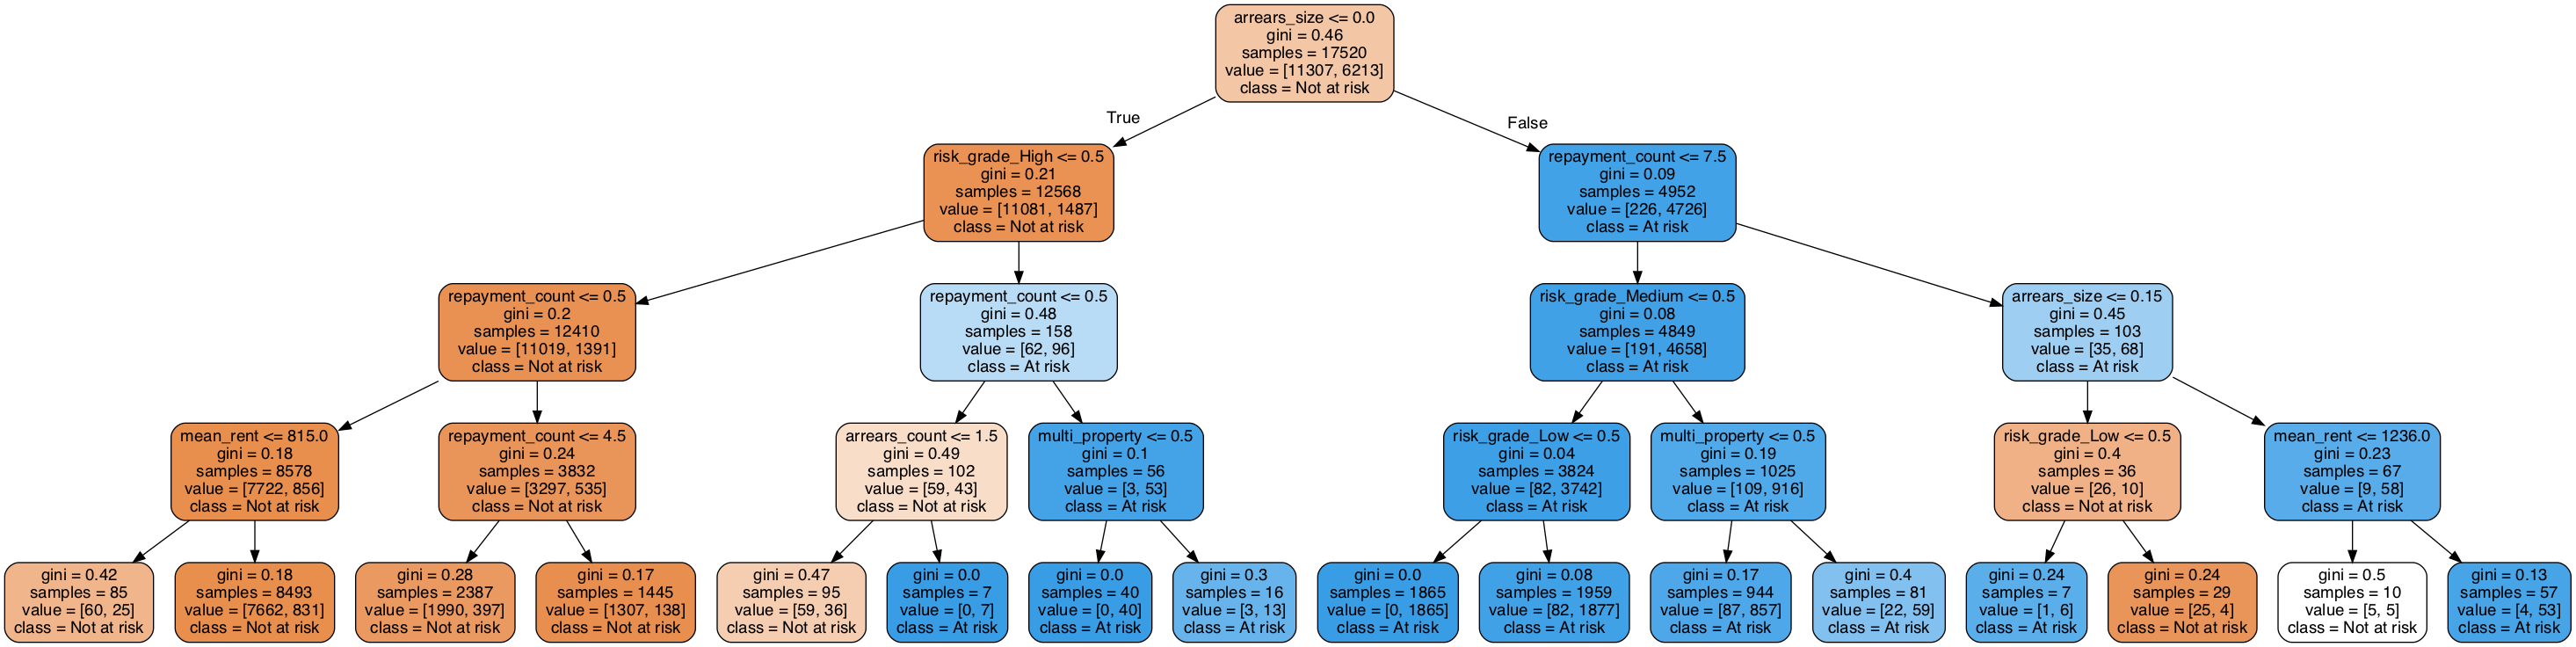

In [44]:
dot_data = StringIO()
export_graphviz(DT_train, out_file=dot_data, feature_names = X_train.columns,
                rounded = True, proportion = False, class_names=["Not at risk","At risk"],
                precision = 2, filled = True)
export_graphviz

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### Summary and conclusion:

The analysis above indicates that the decision tree performs exceedingly well in terms of accuracy as it achieves 95% on the validation set with a max_depth of 50 (with the gini index). Given that we reach a high accuracy (>90%) even with a one-digit max depth, and in order to tackle a common issue, which is the overfitting, we also validate our results using the K-fold approach (cv=3).  The k-fold support this performance.  We then proceed to checking the confusion matrix on the validation set, and we note that both sensitivity and specificity score relatively high (92% and 97% respectively). 

We finally run our model with a much lower max depth (4), to help visualise the tree logic.  Even at max depth of 4, we manage an accuracy of 90.7% on the validation data set.

We continue our analysis with the remaining shortlisted methods.

## Approach 2: K Nearest Neighbours (KNN)

We proceed with a second classification method: the KNN approach. 

**Step 1:**   
We create a function,which first trains a KNN classifier for each value of k on the Training data set, evaluates its accuracy and AUC score against the Validation data set, and persist these scores in a dictionary for analysis.

In [45]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

# A dictionary to store the accuracy and ROC AUC Scores for each K-Nearest Neighbour classifier

def summary_accuracy_and_AUC(k_start = 1, k_end = 101, q = 2):
    summary = {}
    for k in range(k_start,k_end):  
        knn = KNeighborsClassifier(n_neighbors=k, p=q)
        knn.fit(X_train, y_train)
        pred_i = knn.predict(X_val)

        # Calculate Accuracy
        accuracy = accuracy_score(y_val, pred_i)

        # Calculate AUC Score
        pred_proba_i = knn.predict_proba(X_val)[:,1]
        fpr, tpr, tholds = roc_curve(y_val, pred_proba_i)
        roc_auc = auc(fpr, tpr)

        # Store accuracy and auc_scores for analysis
        summary[k]={'accuracy':accuracy, 'auc_score':roc_auc}
    return summary

**Step 2:**   
We proceed to train the k-Nearest Neighbours classifiers for k = 1,2,...,20. In the plot summary below we use q=2 (Euclidean distance) in order to plot the Accuracy and AUC. Despite q=1 and q=2 given us roughly similar results, we use the larger k to help eliminate noise in the model.

**Observations:**.  
We can see from the plot below the AUC_score peaks at k=5 while the accuracy peaks at k=2, and then both gradually decrease.

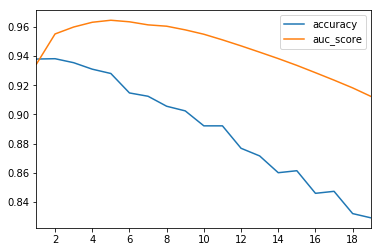

k with highest Accuracy:  2  (value: 0.938249058326675 )
k with highest AUC Score:  5  (value: 0.9646654795870194 )


In [46]:
summary = summary_accuracy_and_AUC(k_end = 20, q=2)
summary_df = pd.DataFrame.from_dict(summary, orient='index')
summary_df.plot()
plt.show()

print('k with highest Accuracy: ', summary_df['accuracy'].idxmax(), \
      ' (value:', summary_df.loc[summary_df['accuracy'].idxmax()]['accuracy'], ')')
print('k with highest AUC Score: ', summary_df['auc_score'].idxmax(), \
      ' (value:', summary_df.loc[summary_df['auc_score'].idxmax()]['auc_score'], ')')

**Step 3:**  
We proceed with plotting the ROC curves to assess the performance of the k=2 and k=5 classifiers. We also plot the random classifier to illustrate the results' differential between our models and the random classifier.

Note: Scroll down for chart

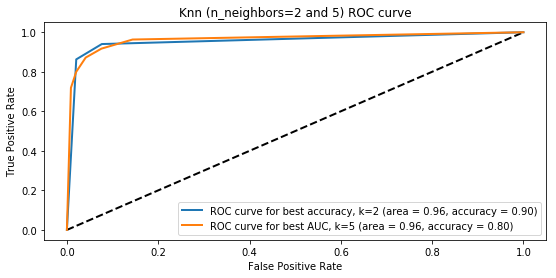

In [47]:
plt.figure(figsize=(9,4))
line_weight = 2

#Setup for best accuracy model, k=2
knn = KNeighborsClassifier(n_neighbors=2, p=2)
knn.fit(X_train, y_train)
y_pred_proba = knn.predict_proba(X_val)[:,1]
fpr, tpr, tholds = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

#Setup for best AUC score model, k=5
knn_2 = KNeighborsClassifier(n_neighbors=5, p=2)
knn_2.fit(X_train, y_train)
y_pred_proba_2 = knn_2.predict_proba(X_val)[:,1]
fpr_2, tpr_2, tholds_2 = roc_curve(y_val, y_pred_proba_2)
roc_auc_2 = auc(fpr_2, tpr_2)

#Plot the random classifier
plt.plot([0,1],[0,1],color = 'black', 
         lw = line_weight, linestyle = '--')

#Plot the ROC curve for best accuracy, k=2
plt.plot(fpr,tpr, lw = line_weight, 
         label='ROC curve for best accuracy, k=2 (area = {:.2f}, accuracy = {:.2f})'. format(roc_auc, 0.9))

#Plot the ROC curve for best AUC, k=5
plt.plot(fpr_2,tpr_2, lw = line_weight, 
         label='ROC curve for best AUC, k=5 (area = {:.2f}, accuracy = {:.2f})'. format(roc_auc_2, 0.8))

#Set x-axis and y-axis ranges from -0.05 to 1.05
plt.xlim ([-0.05, 1.05])
plt.ylim ([-0.05, 1.05])

#Set legend to lower right position
plt.legend(loc = "lower right")

#Give x and y label names
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

#Give title name
plt.title('Knn (n_neighbors=%s) ROC curve' % "2 and 5")

#Plot
plt.show()

### Analysis comments:

Based on the above analysis, we choose k=5 as we get the highest AUC Score (as per graph above, area = 0.96).  We also favor k=5 instead of k=2, as a way to smoothen the model.

We proceed with re-training the model with k=5 (on the Training data set) and store the performance on the **Validation** data set values for analysis.

In [48]:
knn_new = KNeighborsClassifier(n_neighbors=5, p=2)
knn_new.fit(X_train, y_train)

# In-sample (on Training and Validation data sets)
y_pred = knn_new.predict(X_val)

# Calculate Accuracy in-sample
accuracy = round(accuracy_score(y_val, y_pred),3)
    
# Calculate AUC Score in-sample
y_pred_proba = knn_new.predict_proba(X_val)[:,1]
fpr, tpr, tholds = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

print('Accuracy on Validation data set:',accuracy, '\n'\
      +'AUC Score on Validation data set:',round(roc_auc,3), '\n'\
     '-----')

tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
sensitivity = round(tp/(tp+fn),2)
specificity = round(tn/(tn+fp),2)

# Store output
performance_dict['KNN'] = [tn,fp,fn,tp,sensitivity,specificity, accuracy]

print(' tn:',tn,"\n",'fp:',fp,'\n','fn:',fn,'\n','tp:',tp)
print(" sensitivity:", sensitivity,'\n','specificity:',specificity)

Accuracy on Validation data set: 0.928 
AUC Score on Validation data set: 0.965 
-----
 tn: 5432 
 fp: 233 
 fn: 397 
 tp: 2699
 sensitivity: 0.87 
 specificity: 0.96


## Approach 3: Naive Bayes

We proceed with a second classification method: the Naive Bayes

**Step 1:**   
Train a Naive Bauyes classifier on the **Training** data set and use it to predict the output for the **Training** as well as the **Validation** data sets.

In [49]:
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
y_train_pred = gnb.fit(X_train, y_train).predict(X_train)
y_val_pred = gnb.fit(X_train, y_train).predict(X_val)

**Step 2:**

We compute the confusion matrix and analyse and store the performance for this classifier.

**Observations:**  
- The Naive Bayes has a lower accuracy that the models we've looked at so far, it stands at 86.3% on the Training data set and at 85.6% on the Validation data set.
- The Sensitivity of the model is also low, at 66%, although the specificity remains high, at 97%.

In [50]:
accuracy = round(accuracy_score(y_val, y_val_pred),3)

print('Accuracy on Training data set:',round(accuracy_score(y_train, y_train_pred),3), '\n'\
      +'Accuracy on Validation data set:', accuracy, '\n'\
     '-----')

tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred).ravel()
sensitivity = round(tp/(tp+fn),2)
specificity = round(tn/(tn+fp),2)

# Store output
performance_dict['Naive Bayes'] = [tn,fp,fn,tp,sensitivity,specificity, accuracy]

print(' tn:',tn,"\n",'fp:',fp,'\n','fn:',fn,'\n','tp:',tp)
print(" sensitivity:", sensitivity,'\n','specificity:',specificity)

Accuracy on Training data set: 0.863 
Accuracy on Validation data set: 0.856 
-----
 tn: 5468 
 fp: 197 
 fn: 1061 
 tp: 2035
 sensitivity: 0.66 
 specificity: 0.97


## Evaluation of models

The table below summarises the performance measures of each of the models implemented, as well as the Naive Benchmark.

Evaluations comments and decisions:
- The **Decision Tree** model performs best in terms of accuracy of prediction, at 95%, followed by KNN quite closely, at 92.8% and then lagging a bit behind, the Naive Bayes model, with 85.6% accuracy.


- One of the advantages for using the **Decision Tree** classifier is that the output is more clear and comprehensive, and can also be interpreted easier. This is evident from the graph plot shown in our analysis.


- It is noticeable that the Decision Tree reaches a high level of accuracy very quickly. In our analysis, we can see that the maximum accuracy is reached when max_depth=50. However, we also note that even with a max_depth of 4, the accuracy level is above 90%, which is very satisfactory. We are not suggesting we use the max_depth of 4, however if we were to choose a higher max_depth (but not too high), we would still be able to achieve a relatively good level high accuracy, while ensuring we are not overfitting on the training data and making our algorithm computationally less intensive.


- As a general comment, we note that the Decision Trees are said to perform better than i.e. KNN method when we have categorical inputs (even in part).


- The **Decision Tree** model also outperforms the other models on both **sensitivity** and **specificity**, in other words it is the best at accurately predicting both classes (at risk of long-term arrears or not).  

    - The **Naive Bayes** model matches the Decision Tree on specificity, but scores very poorly on sensitivity, and given identifying tenants at risk of not being able to pay their rent is a mission critical situation (for the housing association), one cannot afford to compromise on sensitivity in favour of specificity.  In other words, sensitivity has the higher value.
    
    - The **KNN approach** matches the specificity of the Decision Tree but again scores lower in the sensitivity. For the same reason as above, we deem the Decision Tree a better Classifier. On the positive side for the KNN method, we can say that the KNN approach achieves high accuracy with k=5 (which is already higher than k=2 as suggested by the Accuracy measure), which is reasonably low and therefore we may claim that we have achieved a good balance between bias and variance trade off. 
    
    
- Regarding the Naïve Bayes Classifier, we note that although it is usually quite fast and simple to use, one of the drawbacks is that estimated probabilities are sometimes less reliable. This fact, in combination with the lower accuracy that we get, leads us to conclude that Naïve Bayes is not the best Classifier for this problem.


#### Conclusion:
On the basis of the above, and taking into account the performancr results, we select the **Decision Tree** classifier (with max_depth = 50) as the model of choice for this problem.

In [51]:
model_perf = pd.DataFrame.from_dict(performance_dict, orient='index')
model_perf.rename(columns = {0:'tn', 1:'fp', 2:'fn', 3:'tp', 4:'sensitivity', 5:'specificity', 6:'accuracy'},
                  inplace=True)

model_perf[['accuracy','sensitivity','specificity','tp','fp','tn','fn']].sort_values(['accuracy'], ascending=False)

,accuracy,sensitivity,specificity,tp,fp,tn,fn
Decision Tree,0.950,0.92,0.97,2838,176,5489,258
KNN,0.928,0.87,0.96,2699,233,5432,397
Naive Bayes,0.856,0.66,0.97,2035,197,5468,1061
Naive Benchmark,0.647,0.00,1.00,0,0,5665,3096


## Chosen model's General Performance and Conclusions

We first train the classifier on the **Training + Validation** data set, and use the trained model to predict the output of the **Testing** data set.

**Observations:**  
- The model achieves a 95.5% prediction accuracy, which is quite formidable.
- The model has a sensitivity of 92% and specificity of 97%, it was mostly able to correctly predict the both classes, although 148 false positives (fp) and 248 false negatives were registered.

In [52]:
# Initialise and train classifier
DT_default = DecisionTreeClassifier(random_state = 100, max_depth=50)
DT_default.fit(X_train_val,y_train_val)

# Predict output for Testing data sets
y_test_pred = DT_default.predict(X_test)

accuracy = round(accuracy_score(y_test,y_test_pred),3)
print ('The accuracy of this classifier on the testing data set is: ', accuracy)                                    
                                                                       
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
sensitivity = round(tp/(tp+fn),2)
specificity = round(tn/(tn+fp),2)

print(' tn:',tn,"\n",'fp:',fp,'\n','fn:',fn,'\n','tp:',tp)
print(" sensitivity:", sensitivity,'\n','specificity:',specificity)

The accuracy of this classifier on the testing data set is:  0.955
 tn: 5584 
 fp: 148 
 fn: 248 
 tp: 2781
 sensitivity: 0.92 
 specificity: 0.97


# Objective 4
4. **Can you extend this model to differentiate between short-term and long- term arrears risk?**

To achieve this, we first need to define **Short-Term Arrears** as follows:
- If the maximum time a tenant is in accumulated arrears is between 1-5 months (inclusive) , the tenant is considered to be in short-term arrears, i.e. he/she managed to pay off the accumulated arrears within 5 months of the first arrears accrual date, and the tenant did not fall into a long-term arrears.


**Step 1:** Get a new list of all tenants who have been in short-term arrears

In [53]:
max_counter = rental_data_copy.groupby('name').agg({'arrears_counter':'max'})
tenants_in_short_term_arrears = list(max_counter[(max_counter['arrears_counter'] >=1) &
                                                 (max_counter['arrears_counter'] <6)].index)

**Step 2:** We take a copy the original rental_data_copy, and add a new label called **arrears_type**.

This label holds the following values:
- **Short-Term**: if the tenant is only in short-term arrears (worst case scenario)
- **Long-Term**: if the tenant is in long-term arrears
- **Never**: if the tenant has never been in arrears
 
In the below example:
- **Abe Prophet** is flagged as a tenant who has fallen in long-term arrears
- **Adah Curnutt** is flagged as a tenant who has only fallen in short-term arrears
- While **Arron Huston** (amongst others) has never been in arrears.

In [54]:
arrears_labels = rental_data_copy.copy()
arrears_labels['arrears_type'] = arrears_labels['name'].apply(lambda x:
                                                              'Long-Term' if x in tenants_in_long_term_arrears
                                                              else ('Short-Term' if x in tenants_in_short_term_arrears
                                                              else 'Never'))

# An example to illustrate what this achieves
arrears_labels.groupby(['name']).agg({'arrears_type':'max'}).head(6)

,arrears_type
name,
Aaron Huston,Never
Abbey Kluth,Never
Abe Prophet,Long-Term
Abel Emmett,Never
Abraham Maggi,Never
Adah Curnutt,Short-Term


**Step 3:** We compile a new dataset with the new label (arrears_type). 

In [55]:
labels = arrears_labels.groupby(['name']).agg({'arrears_type':'max'})
new_rental_data2 = inputs.merge(labels,left_on=['name'], right_on=['name'])

# An example to illustrate the output
new_rental_data2.loc[383:388]

,name,houseID,mean_rent,arrears_count,repayment_count,risk_grade,arrears_size,multi_property,dob_available,arrears_type
383,Aida Osterman,27,1948.0,0,0,Low,0.0,0,0,Never
384,Aida Osterman,27,1948.0,0,0,Low,0.0,0,0,Never
385,Aida Osterman,27,1948.0,0,0,Low,0.0,0,0,Never
386,Aimee Macke,28,1318.0,1,1,High,1.0,0,0,Long-Term
387,Aimee Macke,28,1318.0,1,0,High,1.0,0,0,Long-Term
388,Aimee Macke,28,1318.0,1,0,High,1.0,0,0,Long-Term


### **Note:**  
At this stage we could re-run the full model evaluation (carried above) to validate the model, but in the interest of time, we take a shortcut and run a standard **Decision Tree** classifier (our classifier of choice) using only a training data set and a validation data set, and analyse the output.

**Step 4:** Prepare and split data into a training data set and a validation data set.

In [56]:
# Remove name houseid columns
X = pd.get_dummies(new_rental_data2[new_rental_data2.columns[2:-1]])
y = new_rental_data2['arrears_type']

# Use 75% of the data for Training and 25% for Validation
X_train, X_val, y_train, y_val= train_test_split(X, y, test_size=0.25, shuffle = True, random_state = seed)

#print out the count of messages of each data set to check if the code is correct. 
print('X_train:',len(X_train), '\nX_val:',len(X_val))

X_train: 26281 
X_val: 8761


**Step 5:**  
We train a Decision Tree Classifier with the default settings (i.e. Gini criterion, max depth=None). We first train our classifier and then we calculate the accuracy of the tree on the Training and Validation sets.  

We achieve an accuracy of 97.3% on the training set, and accuracy of 93.3% on the validation data set.  

### Conclusion:
In this section we have extended the model to be able to differentiate between Short-Term and Long-Term arrears risk.  We have manage to retain a relatively high out-of-sample accuracy rate.

In [57]:
# Initialise and train classifier
DT_default = DecisionTreeClassifier(random_state = 100)
DT_default.fit(X_train,y_train)

# Predict output for Training and Validation data sets
y_train_pred = DT_default.predict(X_train)
y_val_pred = DT_default.predict(X_val)

print ('Training set accuracy  : ', round(accuracy_score(y_train,y_train_pred),3))
print ('Validation set accuracy: ', round(accuracy_score(y_val,y_val_pred),3))

Training set accuracy  :  0.973
Validation set accuracy:  0.933


We inspect the confusion matrix for insight.

In [58]:
print ('Confusion Matrix:',"\n", confusion_matrix(y_val, y_val_pred, labels=['Never','Short-Term','Long-Term']))

Confusion Matrix: 
 [[4749   72   97]
 [ 120  632   62]
 [ 164   69 2796]]


# Analytics in Business (extra credit)

**Based on your findings from (2)-(4) above, is it possible to translate your analytical insights into actionable business insights?**

As introduced in Q2 (Objective 2), one of the features with the strong predictive power is the accumulated arrear, which can be used to create a credit score for housing association to evaluate the potential risk for each tenant. With sufficient past behaviour of the payments, our predictive model can measure the risk level (risk_grade) for each person and efficiently identify the arrear behaviour with an accuracy of 92% in the out-of-sample set. 

Regarding the potential reasons for becoming arrears, several situations were introduced in McDermont (2007). 

First, the lack of legal and financial knowledge can be a major reason for tenants falling into arrears. Secondly, 'anti-social behaviour' leads to arrears.  Thirdly, some tenants have a perception that they don't have rights or power, and not paying rent might be a form of protest. 

For low risk tenants, it is more likely to be the first case, because the tenants show strong ability to catch up the payment in one month. Housing association should hire financial and legal experts who can help the tenants effectively manage their payments. Offering benefits for payment on time and offering short-term loans may also be beneficial ideas, since the low risk tenants have the ability to pay the bill on time. They might just need some motivation and some help.

For medium risk tenants, who needs 2 to 5 months for catching up the arrears, it mostly belongs to the third case. These tenants need to realise that they have rights, in order to persuade the tenants to pay their rents on time. The recommended approach is to invite tenants to become governors of housing association boards. Thus, they can better understand the governing process, creating power relationships.

For the high risk tenants, whose arrears are mostly long-term and are generally more than 6 months. The behaviour of these tenants are different than the previous two cases. One possible reason is due to lack of working ability for earning income, which may make their life difficult and could not be able to pay back the rents on time. The other could result from the 'anti-social behaviour'. 

To help prevent people from failing into long term arrears, there are several approaches. One is to make sure they have enough deposit prepaid to the bank, in case they have enough money to pay when they are encountering with a difficult time. The other approach is to implement the policy produced by the tenants working with the housing association. These tenants understand the high risk tenants and are willing to contribute and make their own community a better place. Based on our model, once we detected a high risk tenant, it may be necessary to alarm them or discuss to provide help before have to terminate the contract due to long term arrears.

After detecting and classify tenants into three types, we can implement the above approaches. After implementing the approaches, we expect that the risk level for each tenant will on average decrease. We may collect data afterwards and then do analysis again to see if the tendency is favourable. There may be further modification for the apporaches based on the new data. 

# Challenge (extra credit)

**Augment the existing dataset by joining it with demographics data as provided by the US Census website**

The link to the US census data provided in the assignment guidelines was only limited to New York and not California.  We are therefore using an alternative demographics data source; **the IRS ZIP Code data from 2011**.

**Description of data:**  
This data is form the IRS's Statistics of Income (SOI) division, and it holds income related data on each zip code, based on income tax returns for the 2011 Tax Year.  Link to website: https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-2011-zip-code-data-soi

**Feature we will use:**   
In our analysis, we will augment out data set with the average of the **Adjusted gross income (AGI)** for each zip code. The AGI feature would have predictive power for arrears, since it implies one's ability to catch up the arrears. Our hypothesis is that the more income in one area, the less probable on average one in this area would delay the rent payment (and vice versa).  We use the average of the AGI for each zip code, because for each zip code there is an AGI for each of the 7 income bands. If we had more time, we would use a cleaner feature, given the averaging dilutes the predictive power of income.  The code for this data point is **A00100** in the IRS data.

**Ideas for future analysis (but not implemented in our analysis, due to time constraints):**
- The IRS data also contains a **taxed paid amount**, which relates to the tax level in the area. The more tax needed to pay, the less money remains for rent payments. Our hypothesis is that the more taxed paid amount in one area, the more probable on average one in this area would delay the rent payment.
- Another thought was enlightened by the closeness in geographic location among the ZIP codes. It is possible that the grouped closed areas have similar behaviour due to the specific reason in the area, which may include the history, ethnic group or the regulations. And this could be use as a predictor for arrears.   

**Approach:**   
1. Carry out an analysis of the new data point
2. Add new data point to existing data set
3. Run model and report performance

**Step 1:** Analysis of new data point

In [59]:
## Load data 
irs_data = pd.read_excel('./irs_zip_code_data.xlsx')
irs_data = irs_data.groupby(['ZIPCODE']).agg({'A00100':'mean'}).reset_index()
irs_data.head(5)

,ZIPCODE,A00100
0,0,1.834677e+08
1,90001,8.484500e+04
2,90002,7.562867e+04
3,90003,1.006728e+05
4,90004,2.515847e+05


We observe that ~61% of records in our data set don't not have a matching zip code in the IRS data.

In [60]:
zip_list = list(set(irs_data['ZIPCODE']))
print ('Fraction of records without a matching zip code:', 
       round(len(rental_data[~(rental_data['houseZip'].isin(zip_list))])/len(rental_data),3))

Fraction of records without a matching zip code: 0.612


**Analysis notes:**  

In the below section, we check whether the zip code is not missing in a systemmatic way.

The table below shows that, this it is not the case; we have roughly the same fraction of tenants in long-term arrears and not in long-term arrears, whether zip code is missing or not.  

**We can therefore still add and use this feature in our data set, but we will have to drop all records with no matching zip code**, before we proceed with model evaluation.

In [61]:
# Take a copy of the new_rental_data (use to train the models)
new_rental_data3 = new_rental_data.copy()

# Add Zip Code to this new dataset
zip_data_subset = rental_data.groupby(['name','houseID']).agg({'houseZip':'max'})
new_rental_data3 = new_rental_data3.merge(zip_data_subset.reset_index(),
                                          left_on=['name','houseID'], right_on=['name','houseID'], how='left')

# Add rental income from the IRS data - using LEFT merge
new_rental_data3 = new_rental_data3.merge(irs_data[['ZIPCODE', 'A00100']], 
                                          left_on=['houseZip'], right_on=['ZIPCODE'], how='left')

# Plot distribution of NaN income
new_rental_data3['ZIPCODE'].fillna(0, inplace=True)
new_rental_data3['income_available'] = new_rental_data3['ZIPCODE'].apply(lambda x: 0 if x==0 else 1)
new_rental_data3.groupby(['income_available','long_term_arrears_flag']).agg({'long_term_arrears_flag':'count'})

long_term_arrears_flag
income_available long_term_arrears_flag                        
0                0                                        14103
                 1                                         7400
1                0                                         8601
                 1                                         4938

### **Note:**  
At this stage we could re-run the full model evaluation (carried above) to validate the model, but in the interest of time, we take a shortcut and run a standard **Decision Tree** classifier (our classifier of choice) using only a training data set and a validation data set, and analyse the output.

**Step 2:** We clean our data set ready for training, and split in into a training set and a validation set.

In [62]:
# Drop missing income
new_rental_data3 = new_rental_data3[~(new_rental_data3['ZIPCODE']==0)]

# Drop non-required field and reorder dataset
new_rental_data3.drop(['houseZip','ZIPCODE','income_available'], axis=1, inplace=True)

# Get y
y = new_rental_data3['long_term_arrears_flag']

# Get X
new_rental_data3.drop(['long_term_arrears_flag'], axis=1, inplace=True)
X = pd.get_dummies(new_rental_data3[new_rental_data3.columns[2:]])

# Use 75% of the data for Training and 25% for Validation
X_train, X_val, y_train, y_val= train_test_split(X, y, test_size=0.25, shuffle = True, random_state = seed)

#print out the count of messages of each data set to check if the code is correct. 
print('X_train:',len(X_train), '\nX_val:',len(X_val))

X_train: 10154 
X_val: 3385


**Step 3:**  
We train a Decision Tree Classifier with the default settings (i.e. Gini criterion, max depth=None). We first train our classifier and then we calculate the accuracy of the tree on the Training and Validation sets.  

We achieve an accuracy of 99.9% on the training set, and accuracy of 97.9% on the validation data set.  

### Conclusion:
In this section we used the demographics information available via the zip code and the IRS Income Data, to augment our model with an extra feature; Average Zip Code Income.

When training a classifier on the new data, and predicting the accuracy of the model out of sample, we managed to achieve a very high level of accuracy, as well as high sensitivity (97%) and specificity (99%).  Overall add the new feature improve our original model.

In [63]:
# Initialise and train classifier
DT_default = DecisionTreeClassifier(random_state = 100)
DT_default.fit(X_train,y_train)

# Predict output for Training and Validation data sets
y_train_pred = DT_default.predict(X_train)
y_val_pred = DT_default.predict(X_val)

print ('Training set accuracy  : ', round(accuracy_score(y_train,y_train_pred),3))
print ('Validation set accuracy: ', round(accuracy_score(y_val,y_val_pred),3))
                                                                                                      
tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred).ravel()
sensitivity = round(tp/(tp+fn),2)
specificity = round(tn/(tn+fp),2)

print(' tn:',tn,"\n",'fp:',fp,'\n','fn:',fn,'\n','tp:',tp)
print(" sensitivity:", sensitivity,'\n','specificity:',specificity)

Training set accuracy  :  0.999
Validation set accuracy:  0.979
 tn: 2127 
 fp: 31 
 fn: 40 
 tp: 1187
 sensitivity: 0.97 
 specificity: 0.99


## References:

McDermont, M. (2007) 'Mixed Messages: Housing Associations and Corporate Governance', Social & Legal Studies, 16(1), pp. 71–94. doi: 10.1177/0964663907073448. 